In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

**Load CIFAR10 Dataset**

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'airplane', 'dog', 'automobile', 'cat', 'deer', 'ship', 'frog', 'truck', 'horse']


In [ ]:
automobile_images = os.listdir(data_dir + "/train/automobile")
print('No. of training examples for automobiles:', len(automobile_images))
print(automobile_images[:5])

No. of training examples for automobiles: 5000
['0434.png', '0230.png', '4475.png', '1200.png', '3790.png']


In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
print('Length of the dataset:', len(dataset))

Length of the dataset: 50000


In [ ]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


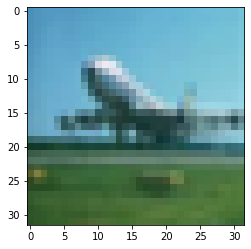

In [ ]:
show_image(*dataset[100])

Label:  airplane (0)


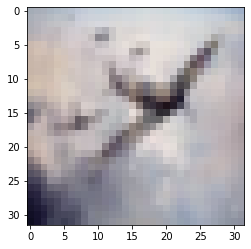

In [ ]:
show_image(*dataset[50])

**Preapre datasets for trainning and validation**

In [ ]:
# Set a random seed to always use the same trainning subset
random_seed = 51
torch.manual_seed(random_seed);

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_imagebatch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


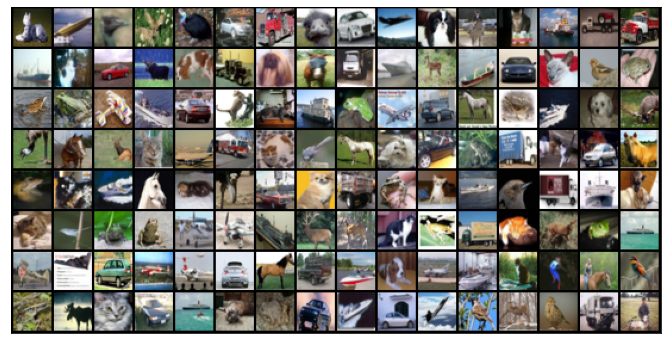

In [ ]:
show_imagebatch(train_dl)

**Define CNN**

In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

**Model0**

In [ ]:
class Cifar10CnnModel0(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            #Conv Layer5: channels 128 to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 256 to 256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            #Linear Layer1: 256*4*4 to 1024
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model0 = Cifar10CnnModel0()
model0

Cifar10CnnModel0(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_param_in_models = []
num_param_in_models.append(count_parameters(model0))
count_parameters(model0)

5851338

**Use GPU for trainning**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

**Place dataloaders and the model into GPU**

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model0, device);

**Model Trainning Phase**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

In [ ]:
#Start tranning
history0 += fit(num_epochs, lr, model0, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.1498, train_acc: 0.9465, val_loss: 0.9975, val_acc: 0.7655
Epoch [1], train_loss: 0.1066, train_acc: 0.9629, val_loss: 1.1740, val_acc: 0.7571
Epoch [2], train_loss: 0.1044, train_acc: 0.9643, val_loss: 1.1936, val_acc: 0.7516
Epoch [3], train_loss: 0.0931, train_acc: 0.9685, val_loss: 1.3457, val_acc: 0.7590
Epoch [4], train_loss: 0.0910, train_acc: 0.9688, val_loss: 1.3104, val_acc: 0.7610
Epoch [5], train_loss: 0.0767, train_acc: 0.9744, val_loss: 1.3736, val_acc: 0.7443
Epoch [6], train_loss: 0.0770, train_acc: 0.9740, val_loss: 1.3709, val_acc: 0.7620
Epoch [7], train_loss: 0.0654, train_acc: 0.9782, val_loss: 1.5089, val_acc: 0.7500
Epoch [8], train_loss: 0.0692, train_acc: 0.9772, val_loss: 1.4641, val_acc: 0.7606
Epoch [9], train_loss: 0.0642, train_acc: 0.9787, val_loss: 1.4709, val_acc: 0.7612
Epoch [10], train_loss: 0.0612, train_acc: 0.9792, val_loss: 1.4711, val_acc: 0.7568
Epoch [11], train_loss: 0.0583, train_acc: 0.9809, val_loss: 1.4667, val_ac

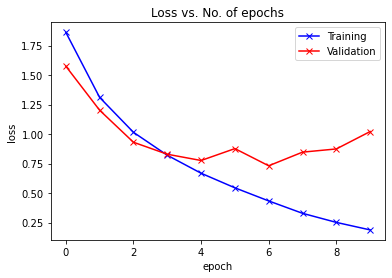

In [ ]:
plot_losses(history0)

In [ ]:
train_losses = []
val_losses = []

In [ ]:
train_losses.append(history0[-1]['train_loss'])
val_losses.append(history0[-1]['val_loss'])

In [ ]:
train_losses[0] = history0[-1]['train_loss']
val_losses[0] = history0[-1]['val_loss']

**Model1**

In [ ]:
class Cifar10CnnModel1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            #Conv Layer5: channels 128 to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 256 to 256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            #Conv Layer7: channels 256 to 512
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer8: channels 512 to 512
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 2 x 2

            nn.Flatten(), 
            #Linear Layer1: 512*2*2 to 1024
            nn.Linear(512*2*2, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model1 = Cifar10CnnModel1()
model1

Cifar10CnnModel1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride

In [ ]:
num_param_in_models.append(count_parameters(model1))
count_parameters(model1)

7294154

In [ ]:
to_device(model1, device);

In [ ]:
#Sanity checking
evaluate(model1, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09547334909439087, 'val_loss': 2.303332567214966}

In [ ]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

In [ ]:
#Start tranning
history1 += fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2895, train_acc: 0.8988, val_loss: 1.0192, val_acc: 0.7343
Epoch [1], train_loss: 0.2375, train_acc: 0.9178, val_loss: 1.0052, val_acc: 0.7332
Epoch [2], train_loss: 0.2110, train_acc: 0.9263, val_loss: 1.0456, val_acc: 0.7509
Epoch [3], train_loss: 0.1777, train_acc: 0.9384, val_loss: 1.1761, val_acc: 0.7464
Epoch [4], train_loss: 0.1611, train_acc: 0.9440, val_loss: 1.1687, val_acc: 0.7325
Epoch [5], train_loss: 0.1316, train_acc: 0.9554, val_loss: 1.2504, val_acc: 0.7371
Epoch [6], train_loss: 0.1365, train_acc: 0.9527, val_loss: 1.2724, val_acc: 0.7399
Epoch [7], train_loss: 0.1180, train_acc: 0.9598, val_loss: 1.4518, val_acc: 0.7336
Epoch [8], train_loss: 0.1177, train_acc: 0.9600, val_loss: 1.2636, val_acc: 0.7362
Epoch [9], train_loss: 0.1089, train_acc: 0.9642, val_loss: 1.3623, val_acc: 0.7474
Epoch [10], train_loss: 0.0933, train_acc: 0.9685, val_loss: 1.3489, val_acc: 0.7350
Epoch [11], train_loss: 0.0966, train_acc: 0.9674, val_loss: 1.4330, val_ac

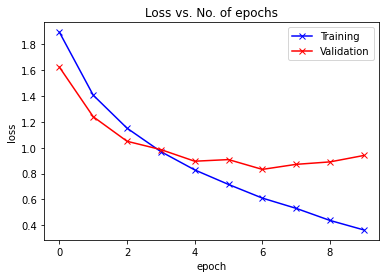

In [ ]:
plot_losses(history1)

In [ ]:
train_losses.append(history1[-1]['train_loss'])
val_losses.append(history1[-1]['val_loss'])

In [ ]:
train_losses[1] = history1[-1]['train_loss']
val_losses[1] = history1[-1]['val_loss']

**Model2**

In [ ]:
class Cifar10CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            #Conv Layer3: channels 64 to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 128 to 128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Flatten(), 
            #Linear Layer1: 128*8*8 to 1024
            nn.Linear(128*8*8, 1024),
            nn.ReLU(),
            #Linear Layer2: 1024 to 512
            nn.Linear(1024, 512),
            nn.ReLU(),
            #Linear Layer3: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = Cifar10CnnModel2()
model2

Cifar10CnnModel2(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=8192, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
num_param_in_models.append(count_parameters(model2))
count_parameters(model2)

9160394

In [ ]:
to_device(model2, device);

In [ ]:
#Sanity checking
evaluate(model2, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09913832694292068, 'val_loss': 2.3028151988983154}

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

In [ ]:
#Start tranning
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.5900, train_acc: 0.4129, val_loss: 1.2561, val_acc: 0.5414
Epoch [1], train_loss: 1.0661, train_acc: 0.6177, val_loss: 0.9654, val_acc: 0.6624
Epoch [2], train_loss: 0.8074, train_acc: 0.7143, val_loss: 0.7848, val_acc: 0.7234
Epoch [3], train_loss: 0.6137, train_acc: 0.7859, val_loss: 0.7418, val_acc: 0.7481
Epoch [4], train_loss: 0.4543, train_acc: 0.8400, val_loss: 0.6964, val_acc: 0.7658
Epoch [5], train_loss: 0.2951, train_acc: 0.8957, val_loss: 0.7557, val_acc: 0.7662
Epoch [6], train_loss: 0.1727, train_acc: 0.9404, val_loss: 0.8914, val_acc: 0.7712
Epoch [7], train_loss: 0.1068, train_acc: 0.9640, val_loss: 1.1562, val_acc: 0.7559
Epoch [8], train_loss: 0.0892, train_acc: 0.9688, val_loss: 1.0955, val_acc: 0.7574
Epoch [9], train_loss: 0.0713, train_acc: 0.9760, val_loss: 1.3765, val_acc: 0.7499


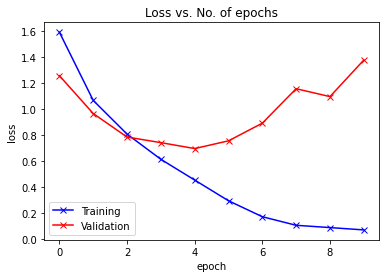

In [ ]:
plot_losses(history2)

In [ ]:
train_losses.append(history2[-1]['train_loss'])
val_losses.append(history2[-1]['val_loss'])

**Model3**

In [ ]:
class Cifar10CnnModel3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 32 to 32
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 32*16*16 to 512
            nn.Linear(32*16*16, 512),
            nn.ReLU(),
            #Linear Layer2: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model3 = Cifar10CnnModel3()
model3

Cifar10CnnModel3(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=8192, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
num_param_in_models.append(count_parameters(model3))
count_parameters(model3)

4210090

In [ ]:
to_device(model3, device);

#Sanity checking
evaluate(model3, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.08910845220088959, 'val_loss': 2.3057572841644287}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4902, train_acc: 0.4644, val_loss: 1.2286, val_acc: 0.5695
Epoch [1], train_loss: 1.0904, train_acc: 0.6132, val_loss: 1.0506, val_acc: 0.6307
Epoch [2], train_loss: 0.8900, train_acc: 0.6851, val_loss: 0.9686, val_acc: 0.6619
Epoch [3], train_loss: 0.7248, train_acc: 0.7462, val_loss: 0.9240, val_acc: 0.6815
Epoch [4], train_loss: 0.5774, train_acc: 0.7985, val_loss: 0.9218, val_acc: 0.6937
Epoch [5], train_loss: 0.4268, train_acc: 0.8539, val_loss: 0.9737, val_acc: 0.6977
Epoch [6], train_loss: 0.2944, train_acc: 0.9022, val_loss: 1.0868, val_acc: 0.6933
Epoch [7], train_loss: 0.1746, train_acc: 0.9437, val_loss: 1.2001, val_acc: 0.6842
Epoch [8], train_loss: 0.0999, train_acc: 0.9723, val_loss: 1.3935, val_acc: 0.6920
Epoch [9], train_loss: 0.0634, train_acc: 0.9828, val_loss: 1.6124, val_acc: 0.6841


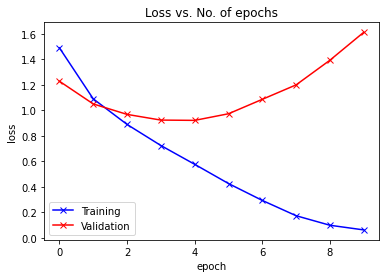

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

plot_losses(history3)

In [ ]:
train_losses.append(history3[-1]['train_loss'])
val_losses.append(history3[-1]['val_loss'])

**Model4**

In [ ]:
class Cifar10CnnModel4(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 16 to 32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 32*16*16 to 512
            nn.Linear(32*16*16, 512),
            nn.ReLU(),
            #Linear Layer2: 512 to 10
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model4 = Cifar10CnnModel4()
model4

Cifar10CnnModel4(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=8192, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
to_device(model4, device);

#Sanity checking
evaluate(model4, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09486442804336548, 'val_loss': 2.303701400756836}

In [ ]:
num_param_in_models.append(count_parameters(model4))
count_parameters(model4)

4205034

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4922, train_acc: 0.4651, val_loss: 1.2486, val_acc: 0.5611
Epoch [1], train_loss: 1.0905, train_acc: 0.6153, val_loss: 1.0756, val_acc: 0.6271
Epoch [2], train_loss: 0.9113, train_acc: 0.6815, val_loss: 0.9739, val_acc: 0.6601
Epoch [3], train_loss: 0.7650, train_acc: 0.7329, val_loss: 0.9361, val_acc: 0.6834
Epoch [4], train_loss: 0.6360, train_acc: 0.7798, val_loss: 0.9129, val_acc: 0.6879
Epoch [5], train_loss: 0.5046, train_acc: 0.8248, val_loss: 0.9522, val_acc: 0.6867
Epoch [6], train_loss: 0.3733, train_acc: 0.8751, val_loss: 1.0467, val_acc: 0.6864
Epoch [7], train_loss: 0.2596, train_acc: 0.9155, val_loss: 1.1774, val_acc: 0.6869
Epoch [8], train_loss: 0.1590, train_acc: 0.9512, val_loss: 1.3359, val_acc: 0.6814
Epoch [9], train_loss: 0.1019, train_acc: 0.9702, val_loss: 1.4840, val_acc: 0.6734


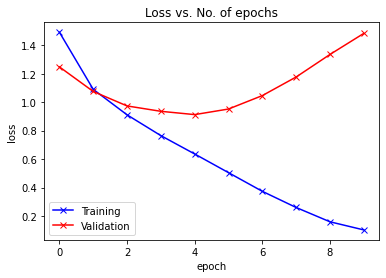

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history4 = fit(num_epochs, lr, model4, train_dl, val_dl, opt_func)

plot_losses(history4)

In [ ]:
train_losses.append(history4[-1]['train_loss'])
val_losses.append(history4[-1]['val_loss'])

**Model5**

In [ ]:
class Cifar10CnnModel5(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 16 to 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 16*16*16 to 256
            nn.Linear(16*16*16, 256),
            nn.ReLU(),
            #Linear Layer2: 256 to 10
            nn.Linear(256, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model5 = Cifar10CnnModel5()
model5

Cifar10CnnModel5(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
to_device(model5, device);

#Sanity checking
evaluate(model5, val_dl)

In [ ]:
num_param_in_models.append(count_parameters(model5))
count_parameters(model5)

1054170

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6330, train_acc: 0.4125, val_loss: 1.3734, val_acc: 0.5106
Epoch [1], train_loss: 1.2862, train_acc: 0.5405, val_loss: 1.2188, val_acc: 0.5677
Epoch [2], train_loss: 1.1346, train_acc: 0.5971, val_loss: 1.1454, val_acc: 0.5918
Epoch [3], train_loss: 1.0215, train_acc: 0.6387, val_loss: 1.1298, val_acc: 0.6004
Epoch [4], train_loss: 0.9340, train_acc: 0.6708, val_loss: 1.0476, val_acc: 0.6329
Epoch [5], train_loss: 0.8549, train_acc: 0.7021, val_loss: 1.0083, val_acc: 0.6499
Epoch [6], train_loss: 0.7744, train_acc: 0.7280, val_loss: 1.0304, val_acc: 0.6468
Epoch [7], train_loss: 0.7031, train_acc: 0.7530, val_loss: 1.0385, val_acc: 0.6510
Epoch [8], train_loss: 0.6284, train_acc: 0.7789, val_loss: 1.0156, val_acc: 0.6597
Epoch [9], train_loss: 0.5552, train_acc: 0.8068, val_loss: 1.0599, val_acc: 0.6633


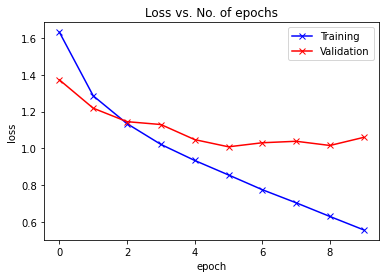

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history5 = fit(num_epochs, lr, model5, train_dl, val_dl, opt_func)

plot_losses(history5)

In [ ]:
train_losses.append(history5[-1]['train_loss'])
val_losses.append(history5[-1]['val_loss'])

**Model6**

In [ ]:
class Cifar10CnnModel6(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 16 to 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 16*16*16 to 128
            nn.Linear(16*16*16, 128),
            nn.ReLU(),
            #Linear Layer2: 128 to 10
            nn.Linear(128, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model6 = Cifar10CnnModel6()
model6

Cifar10CnnModel6(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
to_device(model6, device);

#Sanity checking
evaluate(model6, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09874770045280457, 'val_loss': 2.3055336475372314}

In [ ]:
num_param_in_models.append(count_parameters(model6))
count_parameters(model6)

528474

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6903, train_acc: 0.3901, val_loss: 1.4645, val_acc: 0.4793
Epoch [1], train_loss: 1.3625, train_acc: 0.5149, val_loss: 1.3090, val_acc: 0.5318
Epoch [2], train_loss: 1.2307, train_acc: 0.5648, val_loss: 1.2211, val_acc: 0.5662
Epoch [3], train_loss: 1.1437, train_acc: 0.5986, val_loss: 1.1916, val_acc: 0.5809
Epoch [4], train_loss: 1.0644, train_acc: 0.6247, val_loss: 1.1353, val_acc: 0.6080
Epoch [5], train_loss: 0.9915, train_acc: 0.6515, val_loss: 1.0959, val_acc: 0.6119
Epoch [6], train_loss: 0.9243, train_acc: 0.6764, val_loss: 1.0558, val_acc: 0.6355
Epoch [7], train_loss: 0.8684, train_acc: 0.6954, val_loss: 1.0107, val_acc: 0.6524
Epoch [8], train_loss: 0.8220, train_acc: 0.7114, val_loss: 1.0017, val_acc: 0.6607
Epoch [9], train_loss: 0.7739, train_acc: 0.7274, val_loss: 1.0204, val_acc: 0.6561


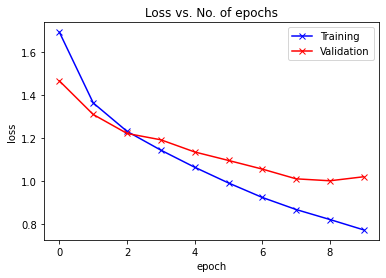

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history6 = fit(num_epochs, lr, model6, train_dl, val_dl, opt_func)

plot_losses(history6)

In [ ]:
train_losses.append(history6[-1]['train_loss'])
val_losses.append(history6[-1]['val_loss'])

**Model7**

In [ ]:
class Cifar10CnnModel7(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 16 to 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 16*16*16 to 64
            nn.Linear(16*16*16, 64),
            nn.ReLU(),
            #Linear Layer2: 64 to 10
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model7 = Cifar10CnnModel7()
model7

Cifar10CnnModel7(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
to_device(model7, device);

#Sanity checking
evaluate(model7, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.10202205181121826, 'val_loss': 2.3054254055023193}

In [ ]:
num_param_in_models.append(count_parameters(model7))
count_parameters(model7)

265626

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6993, train_acc: 0.3945, val_loss: 1.4732, val_acc: 0.4766
Epoch [1], train_loss: 1.3406, train_acc: 0.5231, val_loss: 1.2664, val_acc: 0.5552
Epoch [2], train_loss: 1.1919, train_acc: 0.5816, val_loss: 1.2301, val_acc: 0.5707
Epoch [3], train_loss: 1.0965, train_acc: 0.6150, val_loss: 1.1326, val_acc: 0.6064
Epoch [4], train_loss: 1.0291, train_acc: 0.6394, val_loss: 1.0897, val_acc: 0.6171
Epoch [5], train_loss: 0.9639, train_acc: 0.6611, val_loss: 1.0552, val_acc: 0.6302
Epoch [6], train_loss: 0.9063, train_acc: 0.6837, val_loss: 1.0369, val_acc: 0.6364
Epoch [7], train_loss: 0.8651, train_acc: 0.6973, val_loss: 1.0107, val_acc: 0.6516
Epoch [8], train_loss: 0.8183, train_acc: 0.7163, val_loss: 1.0295, val_acc: 0.6447
Epoch [9], train_loss: 0.7832, train_acc: 0.7270, val_loss: 1.0012, val_acc: 0.6592


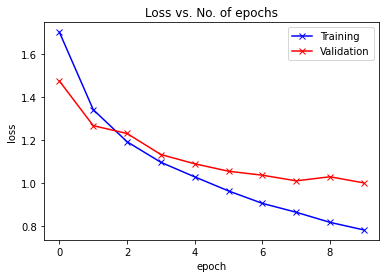

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history7 = fit(num_epochs, lr, model7, train_dl, val_dl, opt_func)

plot_losses(history7)

In [ ]:
train_losses.append(history7[-1]['train_loss'])
val_losses.append(history7[-1]['val_loss'])

**Model8**

In [ ]:
class Cifar10CnnModel8(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 8
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 8 to 8
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            nn.Flatten(), 
            #Linear Layer1: 8*16*16 to 32
            nn.Linear(8*16*16, 32),
            nn.ReLU(),
            #Linear Layer2: 32 to 10
            nn.Linear(32, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model8 = Cifar10CnnModel8()
model8

Cifar10CnnModel8(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=2048, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
to_device(model8, device);

#Sanity checking
evaluate(model8, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.5772174000740051, 'val_loss': 1.2136421203613281}

In [ ]:
num_param_in_models.append(count_parameters(model8))
count_parameters(model8)

66706

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.9675, train_acc: 0.6608, val_loss: 1.1786, val_acc: 0.5995
Epoch [1], train_loss: 0.9531, train_acc: 0.6655, val_loss: 1.1702, val_acc: 0.6043
Epoch [2], train_loss: 0.9425, train_acc: 0.6702, val_loss: 1.1605, val_acc: 0.6037
Epoch [3], train_loss: 0.9365, train_acc: 0.6733, val_loss: 1.1699, val_acc: 0.6065
Epoch [4], train_loss: 0.9274, train_acc: 0.6745, val_loss: 1.1737, val_acc: 0.6017
Epoch [5], train_loss: 0.9240, train_acc: 0.6768, val_loss: 1.1494, val_acc: 0.6113
Epoch [6], train_loss: 0.9138, train_acc: 0.6807, val_loss: 1.1667, val_acc: 0.6111
Epoch [7], train_loss: 0.9055, train_acc: 0.6831, val_loss: 1.1873, val_acc: 0.6088
Epoch [8], train_loss: 0.8990, train_acc: 0.6867, val_loss: 1.1525, val_acc: 0.6085
Epoch [9], train_loss: 0.8919, train_acc: 0.6898, val_loss: 1.1622, val_acc: 0.6014
Epoch [10], train_loss: 0.8868, train_acc: 0.6885, val_loss: 1.1756, val_acc: 0.6055
Epoch [11], train_loss: 0.8757, train_acc: 0.6927, val_loss: 1.1728, val_ac

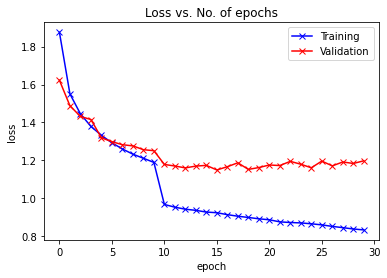

In [ ]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history8 += fit(num_epochs, lr, model8, train_dl, val_dl, opt_func)

plot_losses(history8)

In [ ]:
train_losses.append(history8[-1]['train_loss'])
val_losses.append(history8[-1]['val_loss'])

**Model9**

In [ ]:
class Cifar10CnnModel9(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 8
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 8 to 8
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            #Conv Layer3: channels 8 to 16
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 16 to 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 8 x 8

            #Conv Layer5: channels 16 to 32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 32 to 32
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 4 x 4

            nn.Flatten(), 
            #Linear Layer1: 32*4*4 to 32
            nn.Linear(32*4*4, 32),
            nn.ReLU(),
            #Linear Layer2: 32 to 10
            nn.Linear(32, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model9 = Cifar10CnnModel9()
model9

Cifar10CnnModel9(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=512, out_features=32, bias=True)
    (17): ReLU()
    (18): Linear(in_features=32, out_

In [ ]:
to_device(model9, device);

#Sanity checking
evaluate(model9, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.5734260082244873, 'val_loss': 1.2039254903793335}

In [ ]:
num_param_in_models.append(count_parameters(model9))
count_parameters(model9)

34930

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.1336, train_acc: 0.5944, val_loss: 1.1788, val_acc: 0.5835
Epoch [1], train_loss: 1.0991, train_acc: 0.6085, val_loss: 1.1919, val_acc: 0.5761
Epoch [2], train_loss: 1.0776, train_acc: 0.6148, val_loss: 1.1743, val_acc: 0.5833
Epoch [3], train_loss: 1.0491, train_acc: 0.6262, val_loss: 1.1130, val_acc: 0.6001
Epoch [4], train_loss: 1.0191, train_acc: 0.6365, val_loss: 1.1312, val_acc: 0.6056
Epoch [5], train_loss: 1.0025, train_acc: 0.6434, val_loss: 1.0830, val_acc: 0.6198
Epoch [6], train_loss: 0.9776, train_acc: 0.6495, val_loss: 1.1026, val_acc: 0.6178
Epoch [7], train_loss: 0.9557, train_acc: 0.6595, val_loss: 1.0696, val_acc: 0.6228
Epoch [8], train_loss: 0.9383, train_acc: 0.6676, val_loss: 1.0345, val_acc: 0.6335
Epoch [9], train_loss: 0.9194, train_acc: 0.6737, val_loss: 1.0382, val_acc: 0.6330
Epoch [10], train_loss: 0.9008, train_acc: 0.6822, val_loss: 1.0386, val_acc: 0.6326
Epoch [11], train_loss: 0.8838, train_acc: 0.6864, val_loss: 1.0230, val_ac

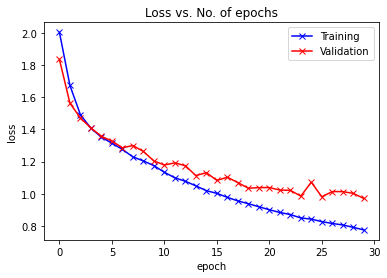

In [ ]:
num_epochs = 20
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history9 += fit(num_epochs, lr, model9, train_dl, val_dl, opt_func)

plot_losses(history9)

In [ ]:
train_losses.append(history9[-1]['train_loss'])
val_losses.append(history9[-1]['val_loss'])

**Model10**

In [ ]:
class Cifar10CnnModel10(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #Conv Layer1: channels 3 to 8
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            #Conv Layer2: channels 8 to 8
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            #Conv Layer3: channels 8 to 16
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer4: channels 16 to 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 8 x 8

            #Conv Layer5: channels 16 to 32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer6: channels 32 to 32
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 4 x 4

            #Conv Layer7: channels 32 to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Conv Layer8: channels 64 to 64
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 2 x 2

            nn.Flatten(), 
            #Linear Layer1: 64*2*2 to 32
            nn.Linear(64*2*2, 32),
            nn.ReLU(),
            #Linear Layer2: 32 to 10
            nn.Linear(32, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model10 = Cifar10CnnModel10()
model10

Cifar10CnnModel10(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:
to_device(model10, device);

#Sanity checking
evaluate(model10, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.0985523909330368, 'val_loss': 2.307551145553589}

In [ ]:
num_param_in_models.append(count_parameters(model10))
count_parameters(model10)

82162

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.0798, train_acc: 0.2150, val_loss: 1.8400, val_acc: 0.3190
Epoch [1], train_loss: 1.7504, train_acc: 0.3491, val_loss: 1.7539, val_acc: 0.3671
Epoch [2], train_loss: 1.6073, train_acc: 0.4124, val_loss: 1.5756, val_acc: 0.4273
Epoch [3], train_loss: 1.4957, train_acc: 0.4576, val_loss: 1.5048, val_acc: 0.4610
Epoch [4], train_loss: 1.4131, train_acc: 0.4884, val_loss: 1.4441, val_acc: 0.4798
Epoch [5], train_loss: 1.3488, train_acc: 0.5119, val_loss: 1.3804, val_acc: 0.5185
Epoch [6], train_loss: 1.3016, train_acc: 0.5285, val_loss: 1.3426, val_acc: 0.5256
Epoch [7], train_loss: 1.2560, train_acc: 0.5487, val_loss: 1.3547, val_acc: 0.5178
Epoch [8], train_loss: 1.2066, train_acc: 0.5650, val_loss: 1.2923, val_acc: 0.5431
Epoch [9], train_loss: 1.1636, train_acc: 0.5842, val_loss: 1.2769, val_acc: 0.5476


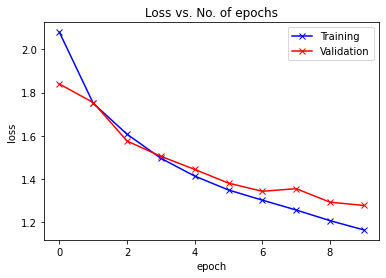

In [ ]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

#Start tranning
history10 = fit(num_epochs, lr, model10, train_dl, val_dl, opt_func)

plot_losses(history10)

In [ ]:
train_losses.append(history10[-1]['train_loss'])
val_losses.append(history10[-1]['val_loss'])

In [ ]:
train_acc = []
val_acc = []

In [ ]:
train_acc.extend((history0[-1]['train_acc'],history1[-1]['train_acc'],history2[-1]['train_acc'],
                  history3[-1]['train_acc'],history4[-1]['train_acc'],history5[-1]['train_acc'],
                  history6[-1]['train_acc'],history7[-1]['train_acc'],history8[-1]['train_acc'],
                  history9[-1]['train_acc'],history10[-1]['train_acc']))
val_acc.extend((history0[-1]['val_acc'],history1[-1]['val_acc'],history2[-1]['val_acc'],
                  history3[-1]['val_acc'],history4[-1]['val_acc'],history5[-1]['val_acc'],
                  history6[-1]['val_acc'],history7[-1]['val_acc'],history8[-1]['val_acc'],
                  history9[-1]['val_acc'],history10[-1]['val_acc']))

**Post processing**

In [ ]:
def plot_all_model_losses(num_param_in_models,train_losses,val_losses):
    plt.plot(num_param_in_models, train_losses, 'o', label="Training loss")
    plt.plot(num_param_in_models, val_losses, 'o', label="Test loss")
    plt.xlabel('Number of parameters')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title('Model loss');

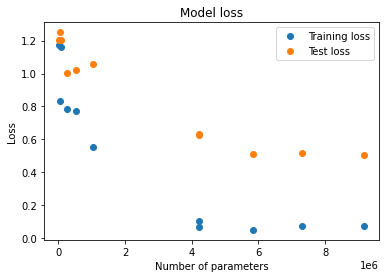

In [ ]:
plot_all_model_losses(num_param_in_models,train_losses,val_losses)

In [ ]:
def plot_all_model_accuracies(num_param_in_models,train_acc,val_acc):
    plt.plot(num_param_in_models, train_acc, 'o', label="Training accuracy")
    plt.plot(num_param_in_models, val_acc, 'o', label="Test accuracy")
    plt.xlabel('Number of parameters')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.title('Model accuracy');

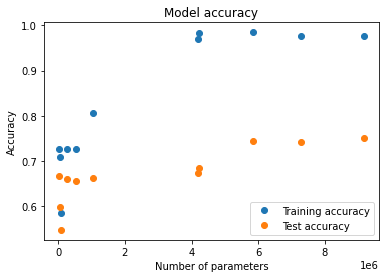

In [ ]:
plot_all_model_accuracies(num_param_in_models,train_acc,val_acc)